Using GPU to train AE model, with Pretrain-Finetune Models. With Image Visualization Features.
Ensure consistent latent dimension is used in both pretrain/finetune
Change Filename Accordingly

In [ ]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'  # Add this BEFORE importing torch
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, ConcatDataset
import torch
import gc


In [2]:
# Modified Dataset class with error handling
class ImageDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.image_files = [f for f in os.listdir(root_dir) 
                          if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        self.transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize((144,256)),  # Maintain (H, W) ordering
            transforms.ToTensor(),
        ])
        print(f"Total images loaded: {len(self.image_files)}")  # Print total images

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path)
        return self.transform(image)


In [ ]:
class AE(nn.Module):
    def __init__(self, latent_dim=128):
        super(AE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),   # (B, 32, H/2, W/2)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # (B, 64, H/4, W/4)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # (B, 128, H/8, W/8)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
        )

        self.flattened_size = 128 * 18 * 32
        self.fc_enc = nn.Linear(self.flattened_size, latent_dim)
        self.fc_dec = nn.Linear(latent_dim, self.flattened_size)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # (B, 64, H/4, W/4)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # (B, 32, H/2, W/2)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),    # (B, 1, H, W)
            nn.Sigmoid(),  # Output in [0, 1]
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(-1, self.flattened_size)
        return self.fc_enc(x)

    def decode(self, z):
        x = self.fc_dec(z)
        x = x.view(-1, 128, 18, 32)
        return self.decoder(x)

    def forward(self, x):
        z = self.encode(x)
        x_recon = self.decode(z)
        return x_recon


In [4]:
def validate_single_image(model, device, image_path):
    # Load and preprocess single image
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((144, 256)),
        transforms.ToTensor(),
    ])
    
    image = Image.open(image_path)
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension
    
    # Generate reconstruction
    model.eval()
    with torch.no_grad():
        recon= model(image_tensor)
    
    # Convert tensors to numpy arrays
    original = image_tensor.cpu().numpy()[0][0]
    reconstruction = torch.sigmoid(recon).cpu().numpy()[0][0]
    
    #original_rotated = np.rot90(original, k=1)        # Rotate 90° counterclockwise
    #reconstruction_rotated = np.rot90(reconstruction, k=1)
    # Plot comparison
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    axes[0].imshow(original, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    axes[1].imshow(reconstruction, cmap='gray')
    axes[1].set_title('Reconstruction')
    axes[1].axis('off')
    
    plt.show()


In [5]:
def loss_func(recon, target, avg_power):
    # Flatten each image in the batch
    recon_flat = recon.view(recon.size(0), -1)
    target_flat = target.view(target.size(0), -1)

    # Compute per-image squared error (sum over pixels)
    squared_error = torch.sum((recon_flat - target_flat) ** 2, dim=1)

    # Normalize by avg power (scalar), avoid divide-by-zero
    nmse = squared_error / (avg_power + 1e-8)

    # Return mean NMSE over batch
    return nmse.mean()


In [6]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split, Subset
import random
import os


def compute_avg_power(loader, device):
    total_power = 0.0
    total_samples = 0
    for data in loader:
        data = data.to(device)
        data_flat = data.view(data.size(0), -1)
        total_power += torch.sum(data_flat ** 2).item()
        total_samples += data.size(0)
    return total_power / total_samples

In [ ]:
import torch
from torch.utils.data import DataLoader, random_split, Subset
import random
import os

def main_pretrain(n_sample=80000, random_seed=42):
    #main_petrain takes n_sample and random_seed as arguments
    #manually set hyperparameters here, including latent_dim, batch_size, epochs, and learning rate
    latent_dim = 2048
    batch_size = 256
    epochs = 20
    lr = 3e-4
    #change log_path to your desired log file name
    log_path = "CHANGE YOUR TRAIN LOG NAME HERE.txt"
    os.makedirs(os.path.dirname(log_path), exist_ok=True) if os.path.dirname(log_path) else None

    print('loaded samples: ' + str(n_sample))

    # Load full dataset_1 first
    full_dataset = ImageDataset(root_dir=r'Preprocessed Images/Museum Art/processed_from_reference')
    full_len = len(full_dataset)

    # Randomly sample n_sample indices with seed
    random.seed(random_seed)
    sampled_indices = random.sample(range(full_len), k=min(n_sample, full_len))
    dataset_1 = Subset(full_dataset, sampled_indices)

    # Train/Val split
    len1 = len(dataset_1)
    train_1, val_1 = random_split(dataset_1, [int(0.8 * len1), len1 - int(0.8 * len1)],
                                  generator=torch.Generator().manual_seed(random_seed))

    train_loader = DataLoader(train_1, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_1, batch_size=batch_size, shuffle=False, pin_memory=True)

    # Model setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = AE(latent_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

    # Compute normalization power
    avg_power = compute_avg_power(train_loader, device)
    print(f"[Pretrain] Avg power: {avg_power:.6f}")
    avg_power = 1

    with open(log_path, "a") as f:
        f.write(f"[Pretrain] Start training with {n_sample} samples...\n")
        for epoch in range(epochs):
            model.train()
            train_loss = 0
            for data in train_loader:
                data = data.to(device)
                optimizer.zero_grad()
                recon = model(data)
                loss = loss_func(recon, data, avg_power)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * data.size(0)

            # Validation
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for data in val_loader:
                    data = data.to(device)
                    recon = model(data)
                    loss = loss_func(recon, data, avg_power)
                    val_loss += loss.item() * data.size(0)

            log_line = (f"[Pretrain] Epoch {epoch+1:03d} | "
                        f"Train Loss: {train_loss / len(train_loader.dataset):.6f} | "
                        f"Val Loss: {val_loss / len(val_loader.dataset):.6f}\n")
            print(log_line.strip())
            f.write(log_line)

    # Save the model
    #torch.save(model.state_dict(), "ae_pretrained_on_dataset1.pth")
    print("[Pretrain] Model saved.")
    return model, device


In [ ]:
trained_model, device = main_pretrain(n_sample=80000, random_seed=42)
torch.save(trained_model.state_dict(), r"Trained Models/Example AE Pretrained Model") #save model to file
# ===== after finishing one training run =====
gc.collect()
torch.cuda.empty_cache()
# ===== now you can start next training run =====

loaded samples: 80000
Total images loaded: 124204
[Pretrain] Avg power: 12140.565078
[Pretrain] Epoch 001 | Train Loss: 1121.681893 | Val Loss: 542.827344
[Pretrain] Epoch 002 | Train Loss: 503.944697 | Val Loss: 437.859199
[Pretrain] Epoch 003 | Train Loss: 444.827396 | Val Loss: 418.322338
[Pretrain] Epoch 004 | Train Loss: 429.072602 | Val Loss: 409.933927
[Pretrain] Epoch 005 | Train Loss: 420.887538 | Val Loss: 405.194590
[Pretrain] Epoch 006 | Train Loss: 414.418057 | Val Loss: 400.785678
[Pretrain] Epoch 007 | Train Loss: 407.700812 | Val Loss: 397.300920
[Pretrain] Epoch 008 | Train Loss: 403.726074 | Val Loss: 394.921028
[Pretrain] Epoch 009 | Train Loss: 401.053440 | Val Loss: 393.141083
[Pretrain] Epoch 010 | Train Loss: 398.911627 | Val Loss: 392.229848
[Pretrain] Epoch 011 | Train Loss: 397.258090 | Val Loss: 391.185160
[Pretrain] Epoch 012 | Train Loss: 396.009363 | Val Loss: 390.429538
[Pretrain] Epoch 013 | Train Loss: 394.636453 | Val Loss: 389.592002
[Pretrain] Epoch 

In [ ]:
from torch.utils.data import ConcatDataset, DataLoader, random_split
import torch
import os

def main_finetune(latent_dim,log_file,pretrained_model):
    # main_finetune takes latent_dim, log_file, and pretrained_model as arguments
    #latent_dim is the dimension of the latent space
    #log_file is the path to the log file where training logs will be saved
    #pretrained_model is the path to the pretrained model weights
    
    rand_seed = 42
    batch_size = 256
    epochs = 15
    lr = 5e-5  # smaller LR for fine-tuning


    log_dir = os.path.dirname(log_file)
    if log_dir:  # only create directory if it's not an empty string
        os.makedirs(log_dir, exist_ok=True)
        
    with open(log_file, "w") as f:
        f.write("[Finetune] Training log\n")
        
    #change paths to your datasets, dataset_2 containes unlabeled SEM images, dataset_3 contains labeled SEM images
    dataset_2 = ImageDataset(root_dir=r'Preprocessed Images\Unlabeled SEM\processed_smaller_20K_normgrey')
    dataset_3 = ImageDataset(root_dir=r'Preprocessed Images\Labeled SEM\ourimg_normgrey')

    len2 = len(dataset_2)
    len3 = len(dataset_3)

    train_2, val_2 = random_split(dataset_2, [int(0.8 * len2), len2 - int(0.8 * len2)],
                                  generator=torch.Generator().manual_seed(rand_seed))
    train_3, val_3 = random_split(dataset_3, [int(0.8 * len3), len3 - int(0.8 * len3)],
                                  generator=torch.Generator().manual_seed(rand_seed))

    train_dataset = ConcatDataset([train_2, train_3])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader_2 = DataLoader(val_2, batch_size=batch_size, shuffle=False, pin_memory=True)
    val_loader_3 = DataLoader(val_3, batch_size=batch_size, shuffle=False, pin_memory=True)
    full_fixed_loader = DataLoader(dataset_3, batch_size=batch_size, shuffle=False, pin_memory=True)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = AE(latent_dim).to(device)
    model.load_state_dict(torch.load(pretrained_model))
    print("[Finetune] Loaded pretrained weights.")
    with open(log_file, "a") as f:
        f.write("[Finetune] Loaded pretrained weights.\n")

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    avg_power = compute_avg_power(train_loader, device)
    print(f"[Finetune] Avg power: {avg_power:.6f}")
    with open(log_file, "a") as f:
        f.write(f"[Finetune] Avg power: {avg_power:.6f}\n")

    avg_power = 1
    print("[Finetune] Start training...")
    with open(log_file, "a") as f:
        f.write("[Finetune] Start training...\n")

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            recon = model(data)
            loss = loss_func(recon, data, avg_power)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)

        model.eval()
        val_loss_2 = val_loss_3 = fixed_val_sum_loss = 0
        with torch.no_grad():
            for loader, loss_accum in [(val_loader_2, 'val_loss_2'), (val_loader_3, 'val_loss_3'), (full_fixed_loader, 'fixed_val_sum_loss')]:
                for data in loader:
                    data = data.to(device)
                    recon = model(data)
                    loss = loss_func(recon, data, avg_power)
                    if loss_accum == 'val_loss_2':
                        val_loss_2 += loss.item() * data.size(0)
                    elif loss_accum == 'val_loss_3':
                        val_loss_3 += loss.item() * data.size(0)
                    else:
                        fixed_val_sum_loss += loss.item() * data.size(0)

        log_msg = (
            f"[Finetune] Epoch {epoch+1:03d} | "
            f"Train Loss: {train_loss / len(train_loader.dataset):.6f} | "
            f"Val Loss (Main): {val_loss_2 / len(val_loader_2.dataset):.6f} | "
            f"Val Loss (Fixed): {val_loss_3 / len(val_loader_3.dataset):.6f} | "
            f"Fixed Val Sum Loss (Full D3): {fixed_val_sum_loss / len(dataset_3):.6f}"
        )
        print(log_msg)
        with open(log_file, "a") as f:
            f.write(log_msg + "\n")



    return model, device


In [ ]:
# ===== after finishing one training run =====
gc.collect()
torch.cuda.empty_cache()
finetuned_model, device = main_finetune(8,'YourLogNameHere',r'Trained Models/Example AE Pretrained Model')
torch.save(finetuned_model.state_dict(), r"Trained Models/Example AE Finetuned Model.pth") #12:08
# ===== after finishing one training run =====
gc.collect()
torch.cuda.empty_cache()

Total images loaded: 20538
Total images loaded: 346
[Finetune] Loaded pretrained weights.
[Finetune] Avg power: 12049.319649
[Finetune] Start training...
[Finetune] Epoch 001 | Train Loss: 426.861371 | Val Loss (Main): 403.757428 | Val Loss (Fixed): 815.528381 | Fixed Val Sum Loss (Full D3): 823.085152
[Finetune] Epoch 002 | Train Loss: 408.102350 | Val Loss (Main): 392.080512 | Val Loss (Fixed): 801.995178 | Fixed Val Sum Loss (Full D3): 809.169266
[Finetune] Epoch 003 | Train Loss: 398.199820 | Val Loss (Main): 379.564299 | Val Loss (Fixed): 799.908569 | Fixed Val Sum Loss (Full D3): 806.485299
[Finetune] Epoch 004 | Train Loss: 391.342214 | Val Loss (Main): 376.342831 | Val Loss (Fixed): 792.934814 | Fixed Val Sum Loss (Full D3): 798.810879
[Finetune] Epoch 005 | Train Loss: 389.703271 | Val Loss (Main): 374.837921 | Val Loss (Fixed): 788.491272 | Fixed Val Sum Loss (Full D3): 794.138763
[Finetune] Epoch 006 | Train Loss: 387.515165 | Val Loss (Main): 373.580716 | Val Loss (Fixed): 

In [9]:
loaded_model = trained_model

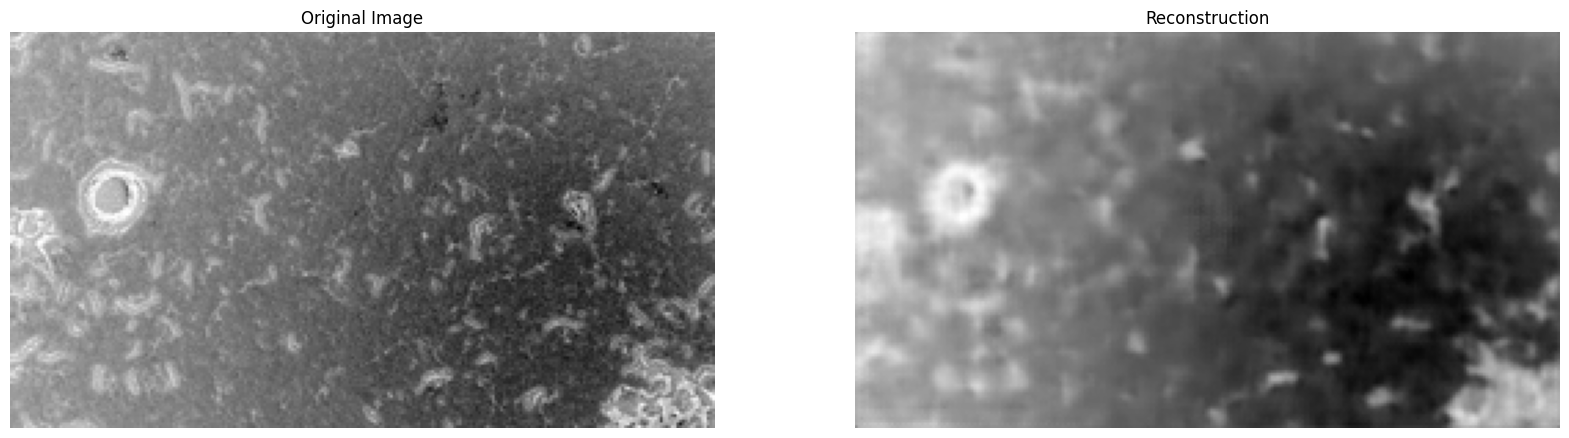

In [ ]:
# Validate with image compared to original image
image_path = r'Preprocessed Images\Unlabeled SEM\processed_smaller_20K_normgrey/L3_93bcfb58d8b994db57aa83e3915d43b1.jpg'  # Replace with your image path

validate_single_image(loaded_model, 'cuda', image_path)

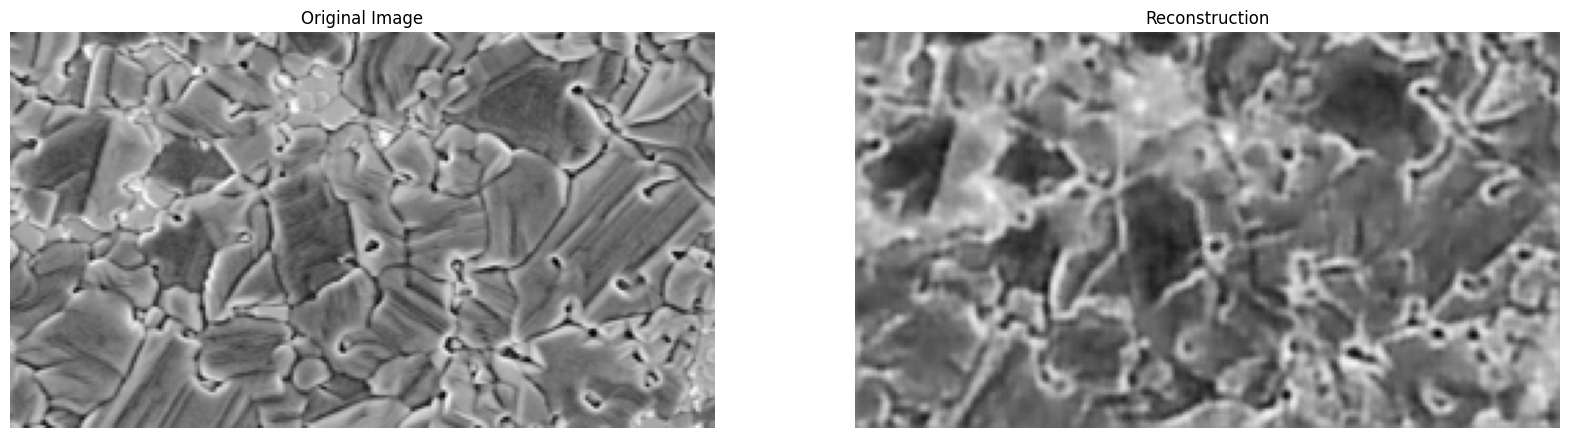

In [ ]:
# Validate with specific image
image_path = r'Preprocessed Images\Unlabeled SEM\processed_smaller_20K_normgreyL3_aa3661359112582a463abd309af0407f.jpg'  # Replace with your image path

validate_single_image(loaded_model, 'cuda', image_path)

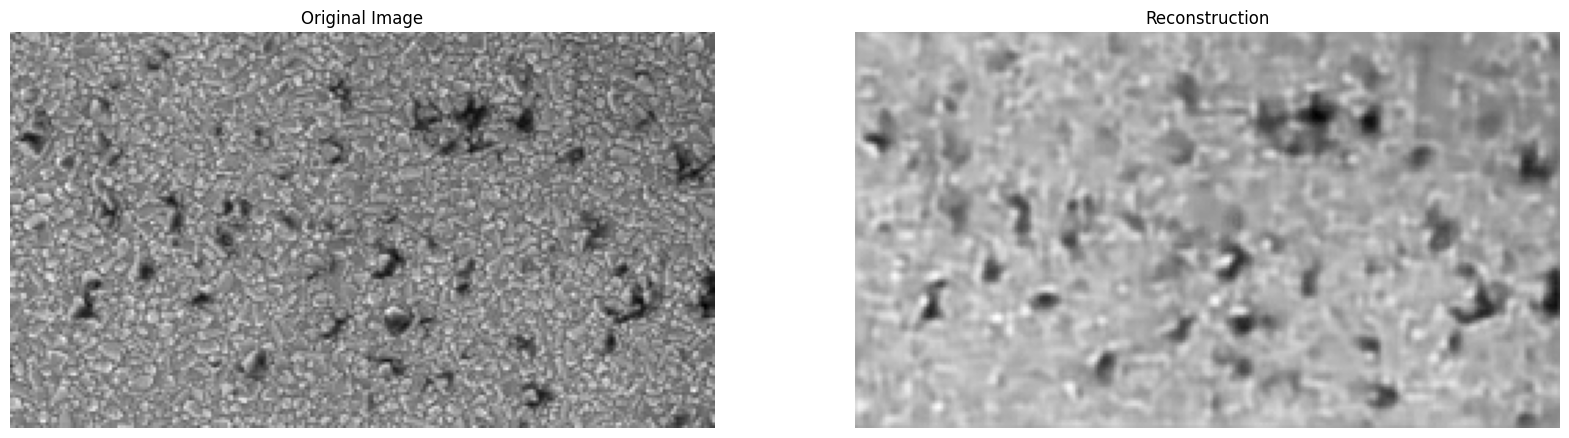

In [ ]:
# Validate with specific image
image_path = r'Preprocessed Images\Unlabeled SEM\processed_smaller_20K_normgreyL3_e860f1f7ed0f7a2723cb3d764b1039a9.jpg'  # Replace with your image path

validate_single_image(loaded_model, 'cuda', image_path)